**1. Libraries**

In [183]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from typing import Dict, Tuple
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.datasets import make_regression
import scipy.linalg as linalg

**2. Mutual Information Selector**

In [184]:
# Target-Aware ARS-QRCP (TAAQ) implementation (minimal, adapted for notebook)
from typing import Tuple
import scipy.linalg as linalg

class TAAQ:
    """
    Target-Aware ARS-QRCP (TAAQ) Feature Selection

    3-Phase Algorithm:
    - Phase 1: QRCP warm-up for k1
    - Phase 2: Target-Projected Residual Sampling (TPRS) with one-step deflation
    - Phase 3: Geometry-Predictive Pruning to size k
    """

    def __init__(self, k: int, k1_fraction: float = 0.5, delta: int = 10,
                epsilon: float = 1e-6, supervised: bool = True):
        self.k = k
        self.k1_fraction = k1_fraction
        self.delta = delta
        self.epsilon = epsilon
        self.supervised = supervised
        self.selected_features_ = None
        self.runtime_ = {}

    def fit(self, M: np.ndarray, y:np.ndarray) -> 'TAAQ':
        start_time = time.time()

        M_std, y_std = self._preprocess(M, y)
        m, n = M_std.shape

        t1 = time.time()
        k1 = int(self.k * self.k1_fraction)
        Q1, R11, S1 = self._phase1_qrcp(M_std, k1)
        self.runtime_['phase1'] = time.time() - t1
        t2 = time.time()
        S2_prime = self._phase2_tprs(M_std, y_std, Q1, S1, k1, self.delta)
        self.runtime_['phase2'] = time.time() - t2

        t3 = time.time()
        S_tmp = np.concatenate([S1, S2_prime])
        S_final = self._phase3_gpp(M_std, y_std, S_tmp, self.k)
        self.runtime_['phase3'] = time.time() - t3

        self.selected_features_ = S_final
        self.runtime_['total'] = time.time() - start_time

        return self

    def _preprocess(self, M: np.ndarray, y: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        m, n = M.shape
        M_std = (M - M.mean(axis=0, keepdims=True)) / (M.std(axis=0, keepdims=True) + 1e-10)
        y_mean = y.mean()
        y_sd = y.std()
        y_std = (y - y_mean) / (y_sd + 1e-10)
        return M_std, y_std

    def _phase1_qrcp(self, M: np.ndarray, k1: int) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
        _, R, piv = linalg.qr(M, mode='economic', pivoting=True)
        S1 = piv[:k1]
        Q1, R11 = linalg.qr(M[:, S1], mode='economic')
        return Q1, R11, S1

    def _phase2_tprs(self, M: np.ndarray, y: np.ndarray, Q1: np.ndarray,
                    S1: np.ndarray, k1: int, delta: int) -> np.ndarray:
        m, n = M.shape
        k2 = self.k - k1
        r_y = y - Q1 @ (Q1.T @ y)
        Q1_T_M = Q1.T @ M
        b = np.sum(M**2, axis=0) - np.sum(Q1_T_M**2, axis=0)
        b = np.maximum(b, self.epsilon)
        s = r_y @ M
        if self.supervised:
            a = s**2 / (b + self.epsilon)
        else:
            a = b

        valid_mask = np.ones(n, dtype=bool)
        valid_mask[S1] = False
        S2_prime = []

        for _ in range(k2+delta):
            a_masked = np.where(valid_mask, a, -np.inf)
            j_star = np.argmax(a_masked)
            S2_prime.append(j_star)
            valid_mask[j_star] = False
            x_j = M[:, j_star]
            P_perp_x = x_j - Q1 @ (Q1.T @ x_j)
            norm_P_perp_x = np.linalg.norm(P_perp_x)
            if norm_P_perp_x > 1e-10:
                u = P_perp_x / norm_P_perp_x
                g = u.T @ M
                alpha = u.T @ r_y
                r_y -= alpha * u
                s -= alpha * g
                if self.supervised:
                    a = s**2 / (b+self.epsilon)
                else:
                    a = b

        return np.array(S2_prime, dtype=int)

    def _phase3_gpp(self, M: np.ndarray, y: np.ndarray,
                   S_tmp: np.ndarray, k:int) -> np.ndarray:
        S_current = S_tmp.copy()
        delta = len(S_tmp) - k
        for _ in range(delta):
            C = M[:, S_current]
            Q, R = linalg.qr(C, mode='economic')
            beta = linalg.solve_triangular(R, Q.T @ y, lower=False)
            R_inv_T = linalg.solve_triangular(R, np.eye(len(S_current)), trans='T', lower=False)
            r_i = np.sum(R_inv_T**2, axis=0)
            d_i = r_i / (beta**2 + self.epsilon)
            i_star = np.argmax(d_i)
            S_current = np.delete(S_current, i_star)
        return S_current

    def transform(self, M: np.ndarray) -> np.ndarray:
        if self.selected_features_ is None:
            raise ValueError("Must fit before transform")
        return M[:, self.selected_features_]

    def fit_transform(self, M: np.ndarray, y: np.ndarray) -> np.ndarray:
        return self.fit(M, y).transform(M)

In [ ]:
class MutualInfoSelector(BaseEstimator, TransformerMixin):
    """
    Feature Selection using Mutual Information (MI)

    - Supports regression and classification.
    - Selects top-k features based on MI scores.
    - Works with scikit-learn pipelines.
    """

    def __init__(self, k: int, supervised: bool = True, task: str = 'regression'):
        self.k = k
        self.supervised = supervised
        self.task = task
        self.selected_features_ = None
        self.mi_scores_ = None
        self.runtime_ = {}

    def fit(self, X: np.ndarray, y: np.ndarray):
        start_time = time.time()

        X_std = (X - X.mean(axis=0)) / (X.std(axis=0) + 1e-10)

        if self.task == 'classification':
            mi = mutual_info_classif(X_std, y, random_state=0)
        else:
            mi = mutual_info_regression(X_std, y, random_state=0)

        self.mi_scores_ = mi
        self.selected_features_ = np.argsort(mi)[-self.k:][::-1]
        self.runtime_['total'] = time.time() - start_time
        return self

    def transform(self, X: np.ndarray) -> np.ndarray:
        return X[:, self.selected_features_]

    def fit_transform(self, X: np.ndarray, y: np.ndarray) -> np.ndarray:
        return self.fit(X, y).transform(X)

    def get_feature_scores(self) -> pd.DataFrame:
        return pd.DataFrame({
            'Feature': np.arange(len(self.mi_scores_)),
            'MI_Score': self.mi_scores_
        }).sort_values('MI_Score', ascending=False).reset_index(drop=True)

**3. Example Usage (Quick Test)**

**4. Evaluation Framework (Metric, Plotting, Tracks)**

In [186]:
def bar_plot(scores: Dict[str, float], title: str, ylabel: str):
    labels = list(scores.keys())
    vals = [scores[k] for k in labels]
    plt.figure()
    plt.title(title)
    plt.bar(labels, vals)
    plt.ylabel(ylabel)
    plt.xticks(rotation=15)
    plt.tight_layout()
    plt.show()

def run_supervised_track(X: np.ndarray, y: np.ndarray, k: int, n_splits: int = 3):
    print('\n' + '='*68)
    print('SUPERVISED TRACK')
    print('='*68)

    Xs = StandardScaler().fit_transform(X)
    ys = (y - y.mean()) / (y.std() + 1e-12)


    methods = {
        'TAAQ': TAAQ(k=k, k1_fraction=0.5, delta=10, supervised=True),
        'Mutual Information Selector': MutualInfoSelector(k=k, task='regression')
    }

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    rows = []

    for fold, (tr, te) in enumerate(kf.split(Xs)):
        Xtr, Xte = Xs[tr], Xs[te]
        ytr, yte = ys[tr], ys[te]
        print(f'\n  Fold {fold+1}/{n_splits}')
        for name, meth in methods.items():
            print('='*68)
            t = time.time()
            meth.fit(Xtr, ytr)
            S = meth.selected_features_
            mdl = Ridge(alpha=1.0).fit(Xtr[:, S], ytr)
            y_pred = mdl.predict(Xte[:, S])
            r2 = r2_score(yte, y_pred)
            rmse = float(np.sqrt(mean_squared_error(yte, y_pred)))
            runtime = time.time() - t
            rows.append(dict(method=name, fold=fold, r2=r2, rmse=rmse, runtime=runtime, k=len(S)))
            print(f'    - {name:25s} | R²={r2: .3f} | RMSE={rmse: .3f} | k={len(S)}')

    df = pd.DataFrame(rows)
    summ = df.groupby('method')[['r2', 'rmse', 'runtime']].mean().round(4)
    print('\nSupervised summary (mean over folds):\n', summ)

    bar_plot(summ['r2'].to_dict(), 'Supervised: R² (higher is better)', 'R²')
    bar_plot(summ['rmse'].to_dict(), 'Supervised: RMSE (lower is better)', 'RMSE')
    bar_plot(summ['runtime'].to_dict(), 'Supervised: Runtime (s)', 'seconds')

    return df

**5. Data Generators**

In [187]:
def dataset_synthetic(m=350, n=120, k_true=25, noise=10, seed=42):
    X, y = make_regression(n_samples=m, n_features=n, n_informative=k_true,
                           noise=noise, random_state=seed)
    return X, y

**6. Experiments**

In [188]:
def main():
    print("\n" + "="*80)
    print("TAAQ MINIMAL EXPERIMENTS")
    print("="*80)

    # 1) Synthetic: both tracks
    print("\n[Dataset] Synthetic linear (m=350, n=120)")
    Xs, ys = dataset_synthetic()
    k = 35
    run_supervised_track(Xs, ys, k=k, n_splits=3)

    print("\nAll done.")

**7. Quick Test**

In [189]:

X, y = make_regression(n_samples=100, n_features=50, n_informative=10, noise=5, random_state=0)


**8. Main Execution**


TAAQ MINIMAL EXPERIMENTS

[Dataset] Synthetic linear (m=350, n=120)

SUPERVISED TRACK

  Fold 1/3
    - TAAQ                      | R²= 0.997 | RMSE= 0.051 | k=35
    - Mutual Information Selector | R²= 0.508 | RMSE= 0.685 | k=35

  Fold 2/3
    - TAAQ                      | R²= 0.998 | RMSE= 0.043 | k=35
    - Mutual Information Selector | R²=-0.018 | RMSE= 0.991 | k=35

  Fold 3/3
    - TAAQ                      | R²= 0.998 | RMSE= 0.041 | k=35
    - Mutual Information Selector | R²= 0.635 | RMSE= 0.622 | k=35

Supervised summary (mean over folds):
                                  r2    rmse  runtime
method                                              
Mutual Information Selector  0.3750  0.7660   0.2245
TAAQ                         0.9979  0.0453   0.0337


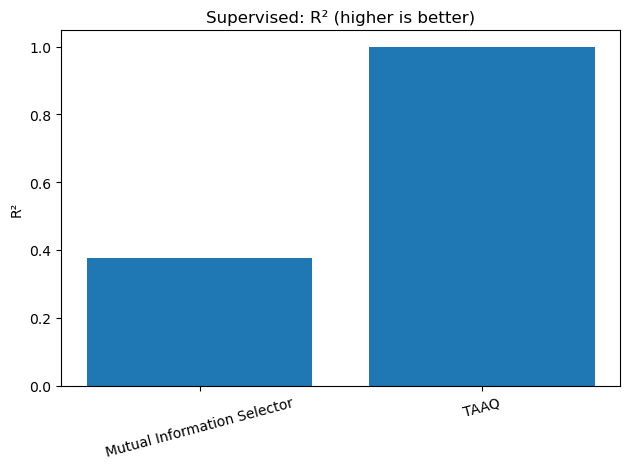

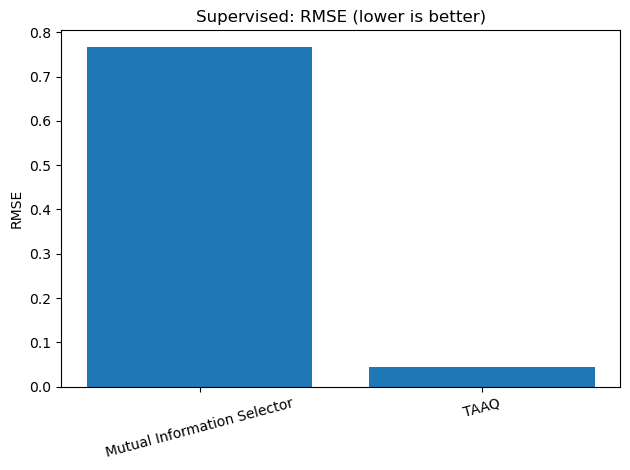

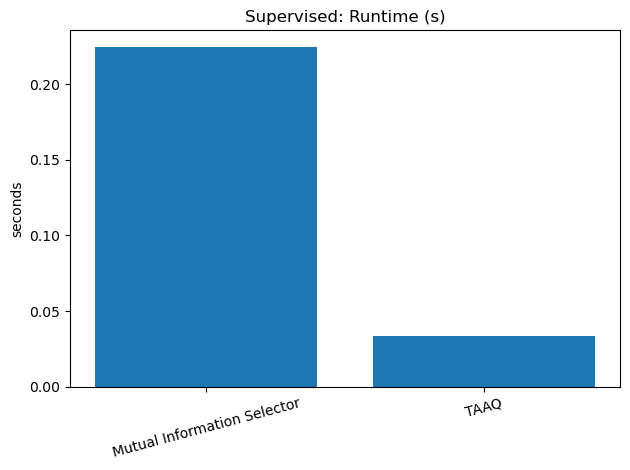


All done.


In [190]:
if __name__ == '__main__':
    main()